In [5]:
from G11_code.data_collection import *
from G11_code.helper_functions import *
from G11_code.indexing import *
from G11_code.clustering import *
# from G11_code.evaluation import evaluation
import seaborn as sns
from tqdm import tqdm

# Data Preparation

In [6]:
article_path = os.path.join("..", "BBC News Summary", "BBC News Summary", "News Articles")
summary_path = os.path.join("..", "BBC News Summary", "BBC News Summary", "Summaries")
print("Article path:", article_path)
print("Summary path:", summary_path)
_article_file_paths_by_cat, _articles_by_cat, _summary_file_paths_by_cat, _summaries_by_cat, category_names = read_files(article_path, summary_path)

Article path: ..\BBC News Summary\BBC News Summary\News Articles
Summary path: ..\BBC News Summary\BBC News Summary\Summaries
Number of Categories: 5
Number of Articles in 'business' Category: 510
Number of Articles in 'entertainment' Category: 386
Number of Articles in 'politics' Category: 417
Number of Articles in 'sport' Category: 511
Number of Articles in 'tech' Category: 401


In [7]:
_summary_sentence_indices_by_cat, faulty_summary_ids = get_summary_sentence_indices(_articles_by_cat, _summaries_by_cat)

number of found summaries: 2217
number of summaries: 2225
99.64%


In [8]:
articles_by_cat = remove_entries(_articles_by_cat, faulty_summary_ids)
articles = flatten(articles_by_cat)
article_file_paths_by_cat = remove_entries(_article_file_paths_by_cat, faulty_summary_ids)
article_file_paths = flatten(article_file_paths_by_cat)
summaries_by_cat = remove_entries(_summaries_by_cat, faulty_summary_ids)
summaries = flatten(summaries_by_cat)
summary_file_paths_by_cat = remove_entries(_summary_file_paths_by_cat, faulty_summary_ids)
summary_file_paths = flatten(summary_file_paths_by_cat)
summary_sentence_indices_by_cat = remove_entries(_summary_sentence_indices_by_cat, faulty_summary_ids)
summary_sentence_indices = flatten(summary_sentence_indices_by_cat)

In [9]:
dict_path_to_articleID = {path:i for i, path in enumerate(article_file_paths)}
def map_path_to_articleID(path):
    path = os.path.normpath(path)
    return dict_path_to_articleID.get(path)

# Options

In [10]:
path = os.path.join(article_path, 'tech', '199.txt')
d = map_path_to_articleID(path)
compute_index = 1

# Experiments

## Unupervised

In [11]:
match compute_index:
    case 0 :
        I = InvertedIndex(0,0)
    case 1:
        index_path = './index/Index.pkl'
        I = indexing(None, index_path = index_path)
    case 2:
        I = indexing(articles)

In [ ]:
print(I.doc_to_string(600))

In [13]:
nltk.help.upenn_tagset('.*')

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [14]:
# load embeddings 
sentence_embeddings_path = os.path.join('./embeddings', 'sentence_embeddings.pkl')
sentence_embeddings_by_cat = pickle_load(sentence_embeddings_path)
document_embeddings_path = os.path.join('./embeddings', 'document_embeddings.pkl')
document_embeddings_by_cat = pickle_load(document_embeddings_path)

In [74]:
np.random.seed(42)
d=10
b = 0.5
k = 1
dM = bert_compute_dissimilarity_matrix(d, file_path=sentence_embeddings_path)
dM0 = tf_idf_compute_dissimilarity_matrix(d, I)
sim2diss1 = lambda S: np.exp(-k(S+b))
sim2diss2 = lambda S: (2/np.pi) * np.arccos((1-b)*S+b)
sim2diss3 = lambda S: b*(1-np.log(1+k*S)/np.log(1+k))
dM2 = tf_idf_compute_dissimilarity_matrix(d, I, conversion_function=sim2diss2)
dM3 = tf_idf_compute_dissimilarity_matrix(d, I, conversion_function=sim2diss3)

In [71]:
Q1, Q2, Q3 = np.percentile(dM2.compressed(), [25, 50, 75])
IQR = Q3 - Q1
ul = np.mean(dM2) + 1.5 * IQR
np.where(dM2 >= Q3)

(array([ 0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  3,
         3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  6,
         6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,
         8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10,
        10, 10], dtype=int64),
 array([ 7,  9, 10,  2,  5,  6,  7,  8,  9,  1,  3,  4,  6,  7,  9, 10,  2,
         5,  6,  9,  2,  5,  7,  8,  9,  1,  3,  4,  6,  7,  8,  9, 10,  1,
         2,  3,  5,  7,  9, 10,  0,  1,  2,  4,  5,  6,  9, 10,  1,  4,  5,
         9, 10,  0,  1,  2,  3,  4,  5,  6,  7,  8, 10,  0,  2,  5,  6,  7,
         8,  9], dtype=int64))

<Axes: ylabel='Density'>

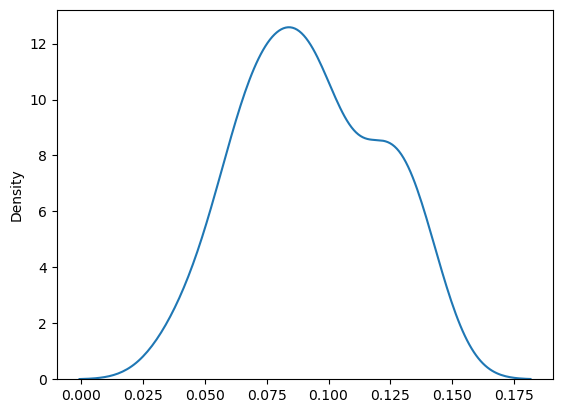

In [72]:
sns.kdeplot(dM.compressed())

<Axes: ylabel='Density'>

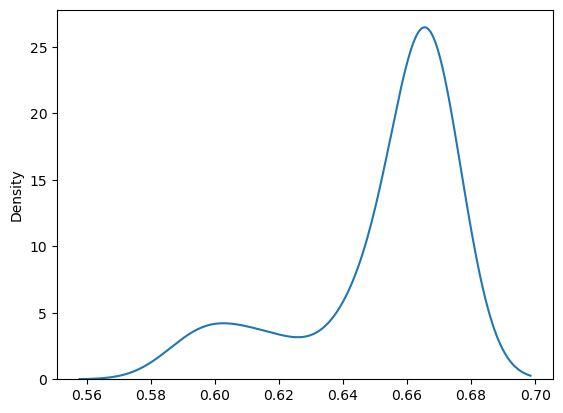

In [73]:
sns.kdeplot(dM2.compressed())

<Axes: ylabel='Density'>

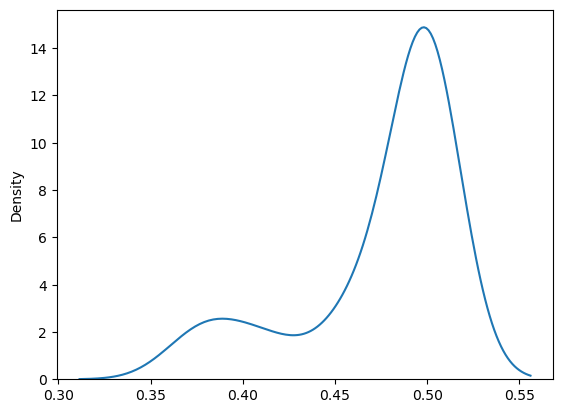

In [75]:
sns.kdeplot(dM3.compressed())

In [60]:
np.arccos(np.min(1-dM2))

1.5707963267948966

In [19]:
n_clust, (labels,_) = sentence_clustering(dM2, algorithm='agglomerative', linkage='complete', kmax=len(dM2)//2)
n_clust, len(labels), labels 

(10,
 20,
 array([ 5,  9,  5,  8,  8,  2,  6,  2,  2,  5,  6,  7,  5,  3,  5,  5, 10,
         4,  1,  1], dtype=int32))

In [20]:
n_clust, (labels, indices) = sentence_clustering(dM2, kmax=len(dM)//2)
n_clust, len(labels), labels, indices

(10,
 20,
 array([0, 4, 2, 5, 5, 8, 5, 8, 2, 2, 5, 6, 7, 3, 4, 2, 9, 1, 8, 8],
       dtype=uint64),
 array([ 0, 17,  9, 13, 14, 10, 11, 12, 18, 16], dtype=uint64))

In [21]:
a = lambda y: lambda x: x+y
b = a(1)
b(8)

9

In [22]:
a = TextBlob('Hello, I\'m Inigo Montoya. You killed my wife. Prepare to die. You are dead.')

In [23]:
from collections import Counter
tokenizer = RegexpTokenizer(r'[\w|-]+')
sent = "I'm appaled that they would refuse to permit us to obtain the state-of-the-art refuse permit"
a = nltk.word_tokenize(sent)
a = tokenizer.tokenize(sent)
for term in a:
    print(term.lower())
    break
c = Counter(nltk.pos_tag(a))
c_ = defaultdict(list)
for ((term,pos), count) in c.items():
    c_[term].append((pos, count))
c_

i


defaultdict(list,
            {'I': [('PRP', 1)],
             'm': [('VBP', 1)],
             'appaled': [('VBN', 1)],
             'that': [('IN', 1)],
             'they': [('PRP', 1)],
             'would': [('MD', 1)],
             'refuse': [('VB', 1), ('NN', 1)],
             'to': [('TO', 2)],
             'permit': [('VB', 1), ('NN', 1)],
             'us': [('PRP', 1)],
             'obtain': [('VB', 1)],
             'the': [('DT', 1)],
             'state-of-the-art': [('JJ', 1)]})

In [24]:
n_cl, clusters = transform_labels(labels)
sorted(zip(clusters, indices), key = lambda tup: len(tup[0]), reverse=True)

[([2, 8, 9, 15], 9),
 ([3, 4, 6, 10], 10),
 ([5, 7, 18, 19], 18),
 ([1, 14], 14),
 ([0], 0),
 ([17], 17),
 ([13], 13),
 ([11], 11),
 ([12], 12),
 ([16], 16)]

In [25]:
clusters

[[0],
 [17],
 [2, 8, 9, 15],
 [13],
 [1, 14],
 [3, 4, 6, 10],
 [11],
 [12],
 [5, 7, 18, 19],
 [16]]

In [26]:
silh = silhouette_samples(dM2, labels, metric='precomputed')
silh_cl = [(silh[clust], clust[np.argmax(silh[clust])]) for clust in clusters]
silh_cl

[(array([0.]), 0),
 (array([0.]), 17),
 (array([0.01078181, 0.02202336, 0.02280171, 0.05349244]), 15),
 (array([0.]), 13),
 (array([ 0.00142233, -0.08791556]), 1),
 (array([0.01086221, 0.03144875, 0.0626584 , 0.13251165]), 10),
 (array([0.]), 11),
 (array([0.]), 12),
 (array([0.04849851, 0.04610888, 0.10882174, 0.09724382]), 18),
 (array([0.]), 16)]

In [27]:
from sklearn.metrics import silhouette_score
silhouette_score(dM2, labels, metric='precomputed')

0.028038003320498578

In [28]:
summarization(dM2, labels)

{18: 4, 10: 4, 15: 4, 1: 2, 0: 1, 17: 1, 13: 1, 11: 1, 12: 1}

In [29]:
clusters = transform_labels(labels)[1]
len([c for c in clusters if len(c) > 3])

3

In [30]:
def summarization_function(d, embed_method, clustering_algorithm, remove_outliers, find_subtopics, evaluate=None, linkage=None, ignore_medoid_centers=False):
    match embed_method:
        case 'tfidf':
            dM = tf_idf_compute_dissimilarity_matrix(d, I)
        case 'bert':
            dM = bert_compute_dissimilarity_matrix(d, file_path=sentence_embeddings_path)
    kmax=len(dM)//2

    n_clust, (labels, cluster_centers) = sentence_clustering(dM, algorithm=clustering_algorithm, kmax=kmax, linkage=linkage, evaluate=evaluate)

    cluster_centers = (not ignore_medoid_centers and cluster_centers) or None    
    return summarization(dM, labels, remove_outliers=remove_outliers, find_subtopics=find_subtopics, cluster_centers=cluster_centers)

In [ ]:
embed_method = 'tfidf'
clustering_algorithm = 'agglomerative'
remove_outliers = True
find_subtopics = False
evaluate = lambda dm,labs: silhouette_score(dm, labs, metric='precomputed')
linkage = 'average'
ignore_medoid_centers = True
args = (embed_method, clustering_algorithm, remove_outliers, find_subtopics, evaluate, linkage, ignore_medoid_centers)
summarize = lambda d: summarization_function(d, *args)

all_accs = summary_compute(article_file_paths_by_cat, summarize, map_path_to_articleID)

In [34]:
print(I.doc_to_string(10))

Document id=10 → vocabulary and term frequencies:
+-------------------------+------+--------+---------------------------------------------------------------------------------------+
|       Vocabulary        | DF_t | TF_d_t |                                      TF/sentence                                      |
+-------------------------+------+--------+---------------------------------------------------------------------------------------+
|         profit          | 113  |   3    |            [(3, 1, [('NN', 1)]), (7, 1, [('NN', 1)]), (8, 1, [('NN', 1)])]            |
|            â            | 646  |   1    |                                 [(1, 1, [('NN', 1)])]                                 |
|          firm           | 459  |   2    |                      [(0, 1, [('NN', 1)]), (1, 1, [('NN', 1)])]                       |
|           one           | 1042 |   1    |                                 [(6, 1, [('CD', 1)])]                                 |
|        investor         

In [ ]:
evaluation()

In [ ]:
n_clust, (labels,_) = sentence_clustering(dM2, algorithm='k-medoids', linkage='complete', kmax=len(dM2)//2)

In [80]:
res = keyword_extraction(2, labels, I)
res

['giant',
 '$ 900m',
 'u',
 'mikhail khodorkovsky',
 'yukos',
 'menatep',
 'u',
 'mikhail khodorkovsky',
 'sale',
 '$ 27.5bn tax claim',
 'rosneft',
 'sale',
 'mikhail khodorkovsky',
 'u',
 'mikhail khodorkovsky',
 'asset',
 'rosneft',
 'u',
 'mikhail khodorkovsky']

## Finding the parameters for the sim2diss func via regression (just for fun)

In [ ]:
ss = [tf_idf_compute_dissimilarity_matrix(d_i, I, conversion_function=lambda S: S).compressed() for d_i in tqdm(range(len(articles)))]

In [ ]:
ds = [np.log(bert_compute_dissimilarity_matrix(d_i, file_path=sentence_embeddings_path).compressed()) for d_i in tqdm(range(len(articles)))]

In [ ]:
fail = set([761, 1182, 1757])
a1 = np.array([np.mean(sims) for i,sims in enumerate(ss) if i not in fail])
b = np.array([np.mean(diss) for i,diss in enumerate(ds) if i not in fail])
a2 = np.ones_like(a1)
a = np.c_[a1, a2]
x = np.linalg.lstsq(a,b,rcond=None)

In [ ]:
fst = -x[0][0]
snd = -x[0][1]/fst
fst,snd

In [ ]:
import scipy.optimize
s_train = np.array(flatten([sims for i,sims in enumerate(ss) if i not in fail]))
d_train = np.array(flatten([diss for i,diss in enumerate(ds) if i not in fail]))
def fun(x, s, d):
    return np.exp(-x[0]*(s+x[1])) - d
res = scipy.optimize.least_squares(fun, np.array([1.5,1.5]), args=(s_train,d_train))
res.x

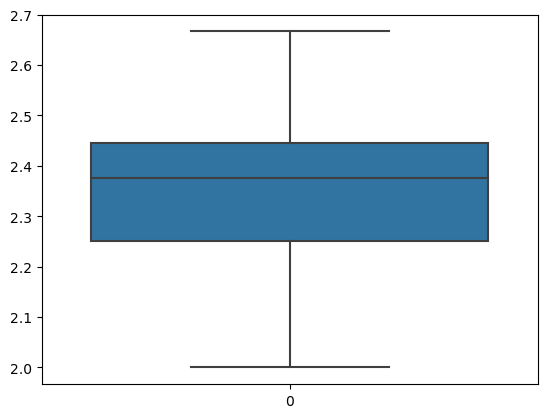

In [77]:
ratios = np.array([len(nltk.sent_tokenize(articles[i]))/len(summary_sentence_indices[i]) for i in range(len(articles))])
sns.boxplot(ratios)
None

## Supervised

In [ ]:
from random import random
from numpy import array
from numpy import cumsum
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed

# create a sequence classification instance
def get_sequence(n_timesteps):
	# create a sequence of random numbers in [0,1]
	X = array([random() for _ in range(n_timesteps)])
	# calculate cut-off value to change class values
	limit = n_timesteps/4.0
	# determine the class outcome for each item in cumulative sequence
	y = array([0 if x < limit else 1 for x in cumsum(X)])
	# reshape input and output data to be suitable for LSTMs
	X = X.reshape(1, n_timesteps, 1)
	y = y.reshape(1, n_timesteps, 1)
	return X, y

# define problem properties
n_timesteps = 10
# define LSTM
model = Sequential()
model.add(LSTM(20, input_shape=(None, 1), return_sequences=True))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# train LSTM
for epoch in range(1000):
	# generate new random sequence
	X,y = get_sequence(n_timesteps)
	# fit model for one epoch on this sequence
	model.fit(X, y, epochs=1, batch_size=1, verbose=2)
# evaluate LSTM
X,y = get_sequence(n_timesteps)
yhat = model.predict_classes(X, verbose=0)
for i in range(n_timesteps):
	print('Expected:', y[0, i], 'Predicted', yhat[0, i])

In [ ]:

from random import random
import tqdm
import numpy.random as rnd 
from numpy import array
from numpy import cumsum
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional

In [ ]:
import tensorflow as tf
print(tf.__version__)


In [ ]:
import keras
keras.__version__

In [ ]:
# create a sequence classification instance
def get_sequence(n_timesteps):
	# create a sequence of random numbers in [0,1]
	X = array([(random(),random()) for _ in range(n_timesteps)])
	# calculate cut-off value to change class values
	limit = n_timesteps/4.0
	# determine the class outcome for each item in cumulative sequence
	y = array([0 if x[0] < limit else 1 for x in cumsum(X,axis=0)])
	# reshape input and output data to be suitable for LSTMs
	X = X.reshape(1, n_timesteps, 2)
	y = y.reshape(1, n_timesteps, 1)
	return X, y

# define LSTM
model = Sequential()
model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(None, 2)))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
# train LSTM
for epoch in range(500):
    #print(epoch, n_timesteps)
    n_timesteps = rnd.randint(2,20)
	# generate new random sequence
    X,y = get_sequence(n_timesteps)
    print(X.shape, y.shape)
	# fit model for one epoch on this sequence
    model.fit(X, y, epochs=1, batch_size=1, verbose=2)

In [ ]:
model = keras.Sequential([
 keras.layers.SimpleRNN(input_shape= (None, 2),units=50, return_sequences= True),
 keras.layers.Dropout(0.2),
 keras.layers.SimpleRNN(units=50, return_sequences= True),
 keras.layers.Dropout(0.2),
 keras.layers.SimpleRNN(units=50, return_sequences= True),
 keras.layers.Dropout(0.2),
 keras.layers.Flatten(),
 keras.layers.Dense(10, activation='relu'),
 keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
 optimizer='adam',
 metrics=['accuracy'])
model.build()